# __mf6_tutorial01__

In [1]:
from pathlib import Path
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import numpy as np

import flopy

In [2]:
h1, Nlay, N, L, H, k, q = 100, 10, 101, 400.0, 50.0, 1.0, -1000.0

# __Sim__

In [3]:
temp_dir = TemporaryDirectory()
workspace = Path(temp_dir.name)
name = "tutorial01_mf6"
sim = flopy.mf6.MFSimulation(sim_name=name, exe_name="mf6", version="mf6", sim_ws=workspace, verbosity_level=0, continue_ = 2)  # __ MFSimulation

In [4]:
tdis = flopy.mf6.ModflowTdis(sim, pname="tdis", time_units="DAYS", nper=1, perioddata=[(1.0, 1, 1.0)])    # perlen, nstp, tsmult

In [5]:
ims = flopy.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE", linear_acceleration="BICGSTAB",)   # solver ?
# MF .pdf           # IMS Iterative Model Solution   # ... EMS Explicit Model Solution (Particle Tracking)

In [6]:
model_nam_file = f"{name}.nam"
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file, save_flows=True, newtonoptions="NEWTON UNDER_RELAXATION",)

In [7]:
# sim.write_simulation()

# __Flow__

In [8]:
bot = np.linspace(-H / Nlay, -H, Nlay)                            # dis
delrow = delcol = L / (N - 1)
dis = flopy.mf6.ModflowGwfdis( gwf, nlay=Nlay, nrow=N, ncol=N, delr=delrow, delc=delcol, top=0.0, botm=bot,)

In [9]:
start = h1 * np.ones((Nlay, N, N))
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)          # ic 

In [10]:
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k)              # node flow

In [11]:
chd_rec = []                                                      # CHD
layer = 0
for row_col in range(0, N):
    chd_rec.append(((layer, row_col, 0), h1))
    chd_rec.append(((layer, row_col, N - 1), h1))
    if row_col != 0 and row_col != N - 1:
        chd_rec.append(((layer, 0, row_col), h1))
        chd_rec.append(((layer, N - 1, row_col), h1))
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_rec)

In [12]:
iper = 0
ra = chd.stress_period_data.get_data(key=iper)
# ra

In [13]:
wel_rec = [(Nlay - 1, int(N / 4), int(N / 4), q)]
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_rec)

In [14]:
headfile = f"{name}.hds"                              # oc
head_filerecord = [headfile]
budgetfile = f"{name}.cbb"
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc( gwf, saverecord=saverecord, head_filerecord=head_filerecord, 
                            budget_filerecord=budget_filerecord, printrecord=printrecord,)

In [15]:
sim.write_simulation()   # verbosity level, 2

In [16]:
success, buff = sim.run_simulation()
assert success, "D'oh'."

In [19]:
h = gwf.output.head().get_data(kstpkper=(0, 0))

<a list of 10 text.Text objects>

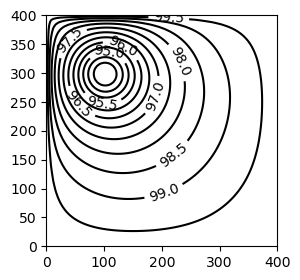

In [58]:
x = y = np.linspace(0, L, N                                            # Layer 1 ?
y = y[::-1]
vmin, vmax = 90.0, 100.0
contour_intervals = np.arange(50, 100.1, .5)     # .5

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.clabel(c, fmt="%2.1f")

<a list of 6 text.Text objects>

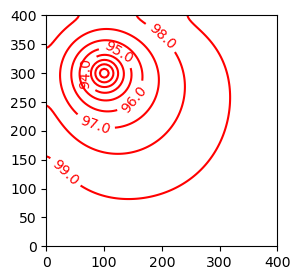

In [39]:
x = y = np.linspace(0, L, N)                                            # Layer 10 ?
y = y[::-1]
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[-5], contour_intervals, colors="red")            # h(-1)
plt.clabel(c, fmt="%1.1f")

<a list of 26 text.Text objects>

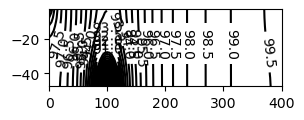

In [60]:
z = np.linspace(-H / Nlay / 2, -H + H / Nlay / 2, Nlay)            # ror 25 ?
fig = plt.figure(figsize=(3, 1))                                   # 9,3
ax = fig.add_subplot(1, 1, 1, aspect="auto")
c = ax.contour(x, z, h[:, int(N / 4), :], contour_intervals, colors="black")
plt.clabel(c, fmt="%1.1f")

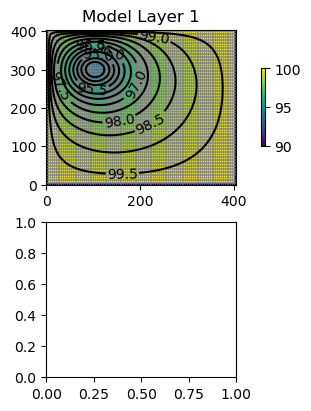

In [78]:
fig, axes = plt.subplots(2, 1, figsize=(3, 4), constrained_layout=True)

# first subplot
ax = axes[0]
ax.set_title("Model Layer 1")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)
pa = modelmap.plot_array(h, vmin=vmin, vmax=vmax)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(h, levels=contour_intervals, colors="black")
ax.clabel(contours, fmt="%2.1f")
cb = plt.colorbar(pa, shrink=0.5, ax=ax)

# second subplot
#ax = axes[1]
#ax.set_title(f"Model Layer {Nlay}")
#modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=Nlay - 1)
#linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
#pa = modelmap.plot_array(h, vmin=vmin, vmax=vmax)
#quadmesh = modelmap.plot_bc("CHD")
#contours = modelmap.contour_array(h, levels=contour_intervals, colors="black")
#ax.clabel(contours, fmt="%2.1f")
#cb = plt.colorbar(pa, shrink=0.5, ax=ax)

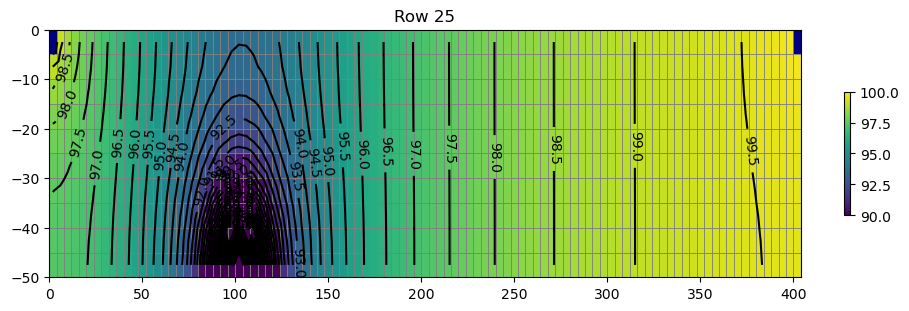

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3), constrained_layout=True)
# first subplot
ax.set_title("Row 25")
modelmap = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": int(N / 4)})
pa = modelmap.plot_array(h, vmin=vmin, vmax=vmax)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(h, levels=contour_intervals, colors="black")
ax.clabel(contours, fmt="%2.1f")
cb = plt.colorbar(pa, shrink=0.5, ax=ax)

# __Flow__Residual__

In [63]:
flowja = gwf.oc.output.budget().get_data(text="FLOW-JA-FACE", kstpkper=(0, 0))[0]

In [64]:
grb_file = workspace / f"{name}.dis.grb"
residual = flopy.mf6.utils.get_residuals(flowja, grb_file=grb_file)

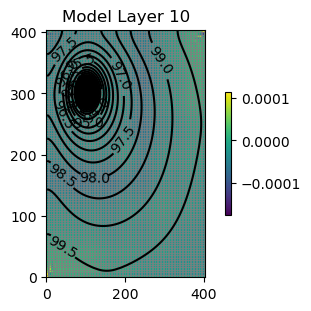

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True)
ax.set_title("Model Layer 10")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=Nlay - 1)
pa = modelmap.plot_array(residual)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(h, levels=contour_intervals, colors="black")
ax.clabel(contours, fmt="%2.1f")
plt.colorbar(pa, shrink=0.5)